# S_Preprocessing

<img src="data/imgs/photo-1472737817652-4120ab61af6c.jpeg">

Компьютеры не понимают человеческие языки, поэтому текстовые данные нужно каким-то образом преобразовывать. Это часто не простой и не тривиальный процесс. На этом занятии мы разберем основные способы очистки данных, нормализации и векторизации. Также мы посмотрим на готовые интрументы, предназначенные для работы с русским языком. В конце занятия мы попробуем порешать задачу автоматического определения тональности твитов.

## Очистка данных

Часто в данных, с которыми нам нужно работать помимо текста присутствует ещё какая-то лишняя информация: тэги, ссылки, код, разметка. От всего этого нужно избавляться.

In [3]:
import string
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from nltk.corpus import stopwords
from string import punctuation
import re
mystem = Mystem()
morph = MorphAnalyzer()

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack, vstack
import matplotlib.pyplot as plt
%matplotlib inline  
pd.set_option('max_colwidth', 1000)

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
train_data = pd.read_csv('data/sentiment_twitter/train_sentiment_ttk.tsv', sep='\t')
test_data = pd.read_csv('data/sentiment_twitter/test_sentiment_ttk.tsv', sep='\t')

In [7]:
train_data.head()

,label,text
0,0,"@mkomov Максим, Вашем письмо мы получили. Наши сотрудники свяжутся с Вами завтра и направят запрос инженерам для проверки. #билайн"
1,0,«Мегафон» стал владельцем 50% акций «Евросети»
2,-1,"RT @fuckkiev: “@EvaKobb: МТС Россия прислала жителям Херсонщины сообщения, в которых обозвала украинцев фашистами? http://t.co/RbSesXlOUZ” …"
3,1,ВИДЕО: http://t.co/PSMLAhR4fI Реклама со смехом МТС - Супер 0
4,-1,"@parfenov1960 потому что МТС достало, а пчел ненавижу с детства, как и их мёд!"


In [8]:
test_data.head()

,label,text
0,-1,RT vzglyad: По делу о работе МТС в Узбекистане США предложили заморозить 300 млн
1,0,RT @kevinuyatukox: http://t.co/ljtrjq91v3 #Кредитные карты мегафон банка
2,0,#Оформить кредитную карту в банке мтс http://t.co/vv1B6PMWgH
3,0,#Как перевести деньги с билайна на кредитную карту
4,0,#Начальник отдела кредитного контроля оао мтс усачева н а


Проверим распределение классов (-1 - негативный отзыв, 1 - положительный, 0 - отрицательный)

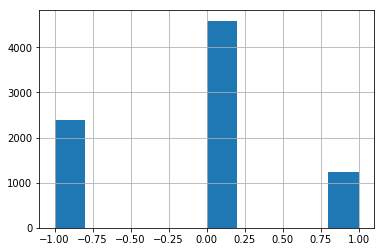

In [9]:
train_data.label.hist()

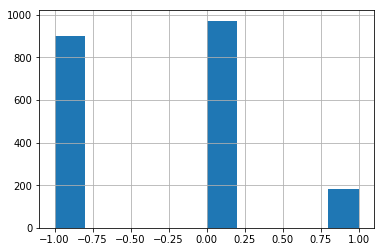

In [10]:
test_data.label.hist()

Видно, что положительный заметно меньше. 

Посмотрим на какой-нибудь негативный твит.

In [11]:
train_data['text'][10]

'@parfenov1960 Фуфло эт ваш Мегафон.просит много,дает мало.'

И на положительный

In [12]:
train_data['text'][9]

'«МегаФон» поможет контролировать расходы на Интернет за границей'

## Бейзлайн

В начале стоит попробовать самый простой возможный вариант. 
Count_vectorizer - без какой-либо нормализации подойдет.

Почти у всего в sklearn индентичный интерфейс. 
1. Нужно инициализировать нужный объект

    ***`vectorizer = CountVectorizer()`***

2. "Обучить" модель на наших данных.
    
    ***`vectorizer.fit(texts)`***
    
3. Преобразовать с помощью обученной модели наши данные в вектора.
    
    ***`X = vectorizer.transform(texts)`***

In [13]:
# посмотрим какие опции есть у count_vectorizer
?CountVectorizer

In [14]:
# у count_vectorizer есть встроенный токенизатор, поэтому можно подавать текст напрямую
# обучим векторайзер на обучающей выборке и преобразуем тексты в векторы
count_vectorizer = CountVectorizer()
count_vectorizer.fit(train_data.text.values) 

X_train = count_vectorizer.transform(train_data.text.values)
X_test = count_vectorizer.transform(test_data.text.values)

In [15]:
# посмотрим на размеры матрицы
# первое число - количество твитов
# второе - размер каждого вектора (равен размеру словаря)
X_train.shape

(8208, 20511)

In [16]:
# нужно чтобы второе число совпадало в обучающей и тестовой выборке
X_test.shape

(2054, 20511)

In [17]:
# выделим классы в отдельные переменные
y_train = train_data.label.values
y_test = test_data.label.values

В качесте классификатора будем использовать Логистическую регрессию.

Интерфейс почти в точности такой же. 
1. Нужно инициализировать нужный объект

    ***`clf = LogisticRegression()`***

2. Обучить модель на наших заранее преобразованных данных.
    
    ***`clf.fit(X)`***
    
3. Предсказать классы на новых данных.
    
    ***`preds = clf.predict(texts)`***

In [18]:
#также можно для начала посмотреть параметры
#основной параметр это С, коэффициент регуляризации.
#Регуляризация нужна для того, чтобы ограничить значения выучиваемых параметров, чтобы избежать переобучения
# l2 стоит по умолчанию и обычно лучше работает, но
# l1 зануляет ненужные признаки и увеличивает значения важных
# поэтому её можно использовать для отбора признаков
#попробуйте перебрать значения (0.01, 0.1, 1(по умолчанию), 10, 100)
?LogisticRegression

In [19]:
clf = LogisticRegression(penalty="l1", C=0.1)
clf.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
# предскажем значения тестовых твитов
y_pred = clf.predict(X_test)

In [21]:
# замерим качество классификации
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ',f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ',f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.69      0.59      0.64       902
          0       0.61      0.80      0.69       972
          1       0.30      0.03      0.06       180

avg / total       0.62      0.64      0.61      2054

Макросредняя F1 мера -  0.46306421211286786
Микросредняя F1 мера -  0.6387536514118792


У некоторых классификаторов можно посмотреть значимость признаков. У логрега они хранится в ***clf.coef_*** . Это массив размером (количество классов, количество признаков). 

Признаки можно достать из векторайзера с помощью метода ***get_feature_names***.

Вместе их можно соотнести встроеной функцией *zip*. При использовании **L1** регуляризации значений признака можно интерпретировать как важность.

In [22]:
def print_important(vectorizer, clf, topn=10):
    features = vectorizer.get_feature_names()
    classes = clf.classes_
    importances = clf.coef_
    for i, cls in enumerate(classes):
        print('Значимые слова для класса - ', cls)
        important_words = sorted(list(zip(features, importances[i])), key=lambda x: abs(x[1]), reverse=True)[:topn]
        print([word for word,_ in important_words])
        print()

In [23]:
print_important(count_vectorizer, clf)

Значимые слова для класса -  -1
['сбой', 'tele2', 'старые', 'нет', 'проблемы', 'тарифов', 'сука', 'просит', 'отключили', 'крыму']

Значимые слова для класса -  0
['пожалуйста', 'гонконгские', 'связь', 'просит', 'цены', '20', 'иа', 'здравствуйте', 'скачать', 'для']

Значимые слова для класса -  1
['узбекистан', 'спасибо', 'клиенты', 'люблю', 'запустил', 'области', 'пожалуйста', '4g', 'увеличил', 'теперь']



### Попробуем теперь TfidfVectorizer.

In [24]:
# интерфейс точно такой же, но немного отличаются параметры
# токенизация по умолчанию также включена, поэтому подаём текст как есть
?TfidfVectorizer

In [25]:
tfidf = TfidfVectorizer()
tfidf.fit(train_data.text.values)
X_train = tfidf.transform(train_data.text.values)
X_test = tfidf.transform(test_data.text.values)

In [26]:
X_train.shape

(8208, 20511)

In [27]:
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
y_pred = clf.predict(X_test)

In [29]:
# замерим качество классификации
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ',f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ',f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.70      0.69      0.69       902
          0       0.66      0.76      0.71       972
          1       0.37      0.09      0.15       180

avg / total       0.65      0.67      0.65      2054

Макросредняя F1 мера -  0.5172604008633273
Микросредняя F1 мера -  0.6708860759493671


Также бывает полезно посмотреть на confision matrix.

Для красоты визуализируем с помощью библиотеки seaborn.

In [30]:
#!pip install seaborn

In [31]:
import seaborn as sns

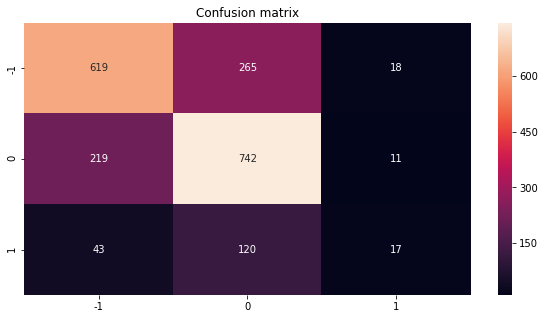

In [32]:
labels = clf.classes_
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

In [33]:
# если не устанавливается, посмотрите просто так
confusion_matrix(y_test, y_pred)

array([[619, 265,  18],
       [219, 742,  11],
       [ 43, 120,  17]])

In [34]:
print_important(tfidf, clf, 20)

Значимые слова для класса -  -1
['сбой', 'tele2', 'старые', 'не', 'сука', 'говно', 'просит', 'проблемы', 'крыму', 'фас', 'нет', 'лежит', 'опять', 'http', 'спасибо', 'тарифов', 'украина', 'для', 'донецке', 'цены']

Значимые слова для класса -  0
['иа', 'просит', 'сбой', 'гонконгские', 'цены', 'границы', 'пожалуйста', 'сн', 'связь', 'ловит', 'здравствуйте', 'инструкция', 'люблю', 'http', 'для', 'ион', 'обратилась', 'долларов', 'даже', 'номер']

Значимые слова для класса -  1
['люблю', 'узбекистан', 'спасибо', 'расходы', 'пожалуйста', 'подарок', 'клиенты', 'бесплатный', 'увеличил', 'защиты', 'не', 'мировое', 'заработал', 'запустил', 'области', 'beeline_rus', 'хорошего', 'реклама', 'водителей', 'номер']



## Улучшение качества классификации

#### По самым характерным словам видно, что в корпусе есть мусор, стоп слова, разные формы одного слова. Чтобы улучшить результат попробуйте почистить данные и добавить нормализацию.

In [35]:
# from nltk.stem.snowball import RussianStemmer


def normalize(text):
    """
    функция нормализации
    
    ::парметры::
    @text - ненормализованный текст (string)
    
    ::returns::
    нормализованный текст (string)
    """
#     stops = stopwords.words('russian')
#     stemmer = RussianStemmer(False)
#     tokens = [word for word in word_tokenize(text)] # if word not in stops
    lemmas = mystem.lemmatize(text) #' '.join(tokens)
#     lemmas = [morph.parse(token)[0].normal_form for token in tokens]
#     stems =  [stemmer.stem(token) for token in tokens]
    
    return ' '.join(lemmas) # text, stems
    

Чтобы применить нормализацию ко всему корпусу, воспользуйтесь функцией apply.

In [36]:
train_data['normalized'] = train_data['text'].apply(normalize)
test_data['normalized'] = test_data['text'].apply(normalize)

Выделим в отдельные признаки количество восклицательных, вопросительных знаков и количество слов в верхнем регистре (рассматриваются слова больше 4 букв, иначе будет также находиться МТС и другие аббревиатуры).

In [37]:
train_data['exclamation'] = train_data['text'].str.findall('!').apply(len)
test_data['exclamation'] = test_data['text'].str.findall('!').apply(len)

In [38]:
train_data['interrogation'] = train_data['text'].str.findall('\?').apply(len)
test_data['interrogation'] = test_data['text'].str.findall('\?').apply(len)

In [39]:
train_data['caps'] = train_data['text'].str.findall('[А-Я]{4,}').apply(len)
test_data['caps'] = test_data['text'].str.findall('[А-Я]{4,}').apply(len)

In [40]:
train_data.head()

,label,text,normalized,exclamation,interrogation,caps
0,0,"@mkomov Максим, Вашем письмо мы получили. Наши сотрудники свяжутся с Вами завтра и направят запрос инженерам для проверки. #билайн","@ mkomov максим , ваш письмо мы получать . наш сотрудник связываться с вы завтра и направлять запрос инженер для проверка . # билайн \n",0,0,0
1,0,«Мегафон» стал владельцем 50% акций «Евросети»,« мегафон » становиться владелец 50 % акция « евросеть »\n,0,0,0
2,-1,"RT @fuckkiev: “@EvaKobb: МТС Россия прислала жителям Херсонщины сообщения, в которых обозвала украинцев фашистами? http://t.co/RbSesXlOUZ” …","RT @ fuckkiev : “ @ EvaKobb : мтс россия присылать житель херсонщина сообщение , в который обзывать украинец фашист ? http :// t . co / RbSesXlOUZ ” … \n",0,1,0
3,1,ВИДЕО: http://t.co/PSMLAhR4fI Реклама со смехом МТС - Супер 0,видео : http :// t . co / PSMLAhR4fI реклама со смех мтс - супер 0 \n,0,0,1
4,-1,"@parfenov1960 потому что МТС достало, а пчел ненавижу с детства, как и их мёд!","@ parfenov1960 потому что мтс доставать , а пчела ненавидеть с детство , как и они мед ! \n",1,0,0


Обучите новую модель на нормализованных данных.

In [41]:
tfidf = TfidfVectorizer() # ngram_range=(1,2)
tfidf.fit(train_data['normalized'].values)

X_train = tfidf.transform(train_data['normalized'].values)
X_test = tfidf.transform(test_data['normalized'].values)

In [42]:
# train_matrix = pd.SparseDataFrame(tfidf.transform(train_data['normalized'].values))
# test_matrix = pd.SparseDataFrame(tfidf.transform(test_data['normalized'].values))
# X_train = train_data.drop(['text', 'label'], axis=1).join(train_matrix)
# X_test = test_data.drop(['text', 'label'], axis=1).join(test_matrix)

In [43]:
# X_train.shape, X_test.shape

In [61]:
clf = LogisticRegression(penalty='l1',  C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [62]:
print(classification_report(y_test, y_pred))
print('Макросредняя F1 мера - ',f1_score(y_test, y_pred, average='macro'))
print('Микросредняя F1 мера - ',f1_score(y_test, y_pred, average='micro'))

             precision    recall  f1-score   support

         -1       0.69      0.67      0.68       902
          0       0.66      0.76      0.70       972
          1       0.46      0.18      0.26       180

avg / total       0.66      0.67      0.66      2054

Макросредняя F1 мера -  0.5477109468756411
Микросредняя F1 мера -  0.6674780915287244


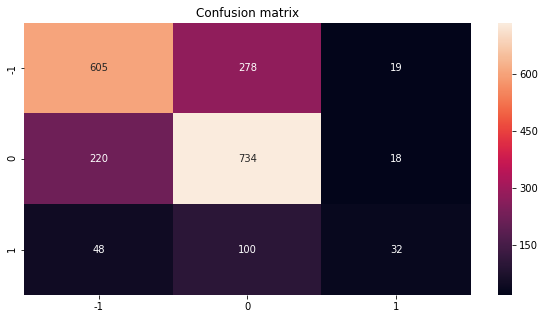

In [65]:
labels = clf.classes_
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

In [66]:
print_important(tfidf, clf, 10)

Значимые слова для класса -  -1
['оштрафовать', 'сбой', 'tele2', 'подорожать', 'гавно', 'повышать', 'сука', 'не', 'восстановление', 'заблокировать']

Значимые слова для класса -  0
['доллар', 'гавно', 'иа', 'подорожать', 'сбой', 'уточнять', 'восстановление', 'оштрафовать', 'ловить', 'pomogite']

Значимые слова для класса -  1
['спасибо', 'защита', 'любить', 'узбекистан', 'подарок', 'расход', 'доллар', 'бесплатный', 'пожалуйста', 'хороший']



In [46]:
X = vstack([X_train, X_test])
X.shape

(10262, 14457)

In [49]:
y = np.hstack([y_train, y_test])
y.shape

(10262,)

In [54]:
param_grid = {'C': [1.e-4, 1.e-3, 1.e-2,
                   1.e-1, 1, 2, 10, 50,
                   100, 1000],
             'penalty': ['l1', 'l2']}
grid_searcher_micro = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=-1, scoring='f1_micro').fit(X, y)

In [55]:
pd.DataFrame(grid_searcher_micro.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
13,0.489689,0.003699,0.725784,0.972739,10,l2,"{'penalty': 'l2', 'C': 10}",1,0.737457,0.970398,...,0.746101,0.969306,0.714425,0.974543,0.685185,0.980877,0.042656,0.001134,0.023342,0.004563
11,0.321358,0.003280,0.716624,0.886864,2,l2,"{'penalty': 'l2', 'C': 2}",2,0.727228,0.886953,...,0.734405,0.879903,0.695419,0.888307,0.683236,0.897442,0.046459,0.001362,0.023147,0.006148
10,0.632806,0.002894,0.715163,0.850516,2,l1,"{'penalty': 'l1', 'C': 2}",3,0.728203,0.846997,...,0.741228,0.843484,0.704191,0.855664,0.675439,0.856395,0.082836,0.000233,0.023158,0.004962
15,0.642460,0.002853,0.714091,0.994445,50,l2,"{'penalty': 'l2', 'C': 50}",4,0.724306,0.994153,...,0.739766,0.993301,0.704191,0.995615,0.668616,0.996711,0.065251,0.000412,0.025722,0.001542
12,20.463784,0.004810,0.713896,0.992180,10,l1,"{'penalty': 'l1', 'C': 10}",5,0.717974,0.991595,...,0.748051,0.990499,0.706628,0.993666,0.667641,0.995371,22.276979,0.003458,0.026864,0.002068


In [56]:
grid_searcher_macro = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=-1, scoring='f1_macro').fit(X, y)

In [57]:
pd.DataFrame(grid_searcher_macro.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
13,0.988244,0.004834,0.645807,0.968358,10,l2,"{'penalty': 'l2', 'C': 10}",1,0.665327,0.966057,...,0.655893,0.965304,0.616126,0.970177,0.599545,0.976729,0.120911,0.001385,0.033611,0.004719
15,1.328820,0.010380,0.641139,0.993791,50,l2,"{'penalty': 'l2', 'C': 50}",2,0.654126,0.993815,...,0.659632,0.992689,0.622151,0.995366,0.586092,0.995801,0.095825,0.006319,0.033793,0.001674
17,1.585664,0.004777,0.636288,0.996728,100,l2,"{'penalty': 'l2', 'C': 100}",3,0.650759,0.996688,...,0.658674,0.995937,0.619793,0.997183,0.580453,0.998360,0.105051,0.000795,0.032730,0.001007
12,3.974544,0.004733,0.635517,0.991165,10,l1,"{'penalty': 'l1', 'C': 10}",4,0.642975,0.990887,...,0.653014,0.989237,0.625574,0.993026,0.581814,0.994240,1.108549,0.000889,0.031112,0.002198
10,1.017328,0.007401,0.630417,0.809768,2,l1,"{'penalty': 'l1', 'C': 2}",5,0.643914,0.807398,...,0.652615,0.802307,0.613740,0.817843,0.583324,0.815242,0.063081,0.003700,0.028134,0.005836


In [58]:
clf_new = LogisticRegression(penalty='l2',  C=10)
clf_new.fit(X_train, y_train)
y_pred_new = clf_new.predict(X_test)

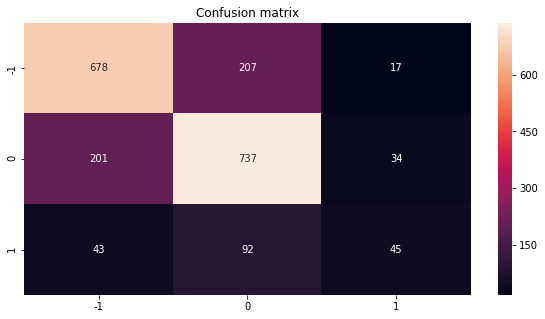

In [59]:
labels = clf_new.classes_
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(y_test, y_pred_new), annot=True, 
            fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
plt.title("Confusion matrix")
plt.show()

In [60]:
print_important(tfidf, clf_new, 10)

Значимые слова для класса -  -1
['гавно', 'оштрафовать', 'не', 'tele2', 'сбой', 'сука', 'повышать', 'плохо', 'подорожать', 'заблокировать']

Значимые слова для класса -  0
['гавно', 'доллар', 'любить', 'оштрафовать', 'восстановление', 'иа', 'ловить', 'сбой', 'даже', 'заебывать']

Значимые слова для класса -  1
['спасибо', 'любить', 'защита', 'узбекистан', 'радовать', 'бесплатный', 'подарок', 'хороший', 'благодарить', 'зарабатывать']

